In [4]:
%matplotlib inline

In [5]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# csv
import csv
import gzip

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
import xgboost as xgb

In [6]:
# get crimes & test csv files as a DataFrame
crimes_df  = pd.read_csv('./input/train.csv')
test_df    = pd.read_csv('./input/test.csv')

# preview the data
crimes_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
crimes_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [8]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
crimes_df = crimes_df.drop(['Descript','Resolution','Address', 'X', 'Y'], axis=1)
test_df   = test_df.drop(['Address', 'X', 'Y'], axis=1)

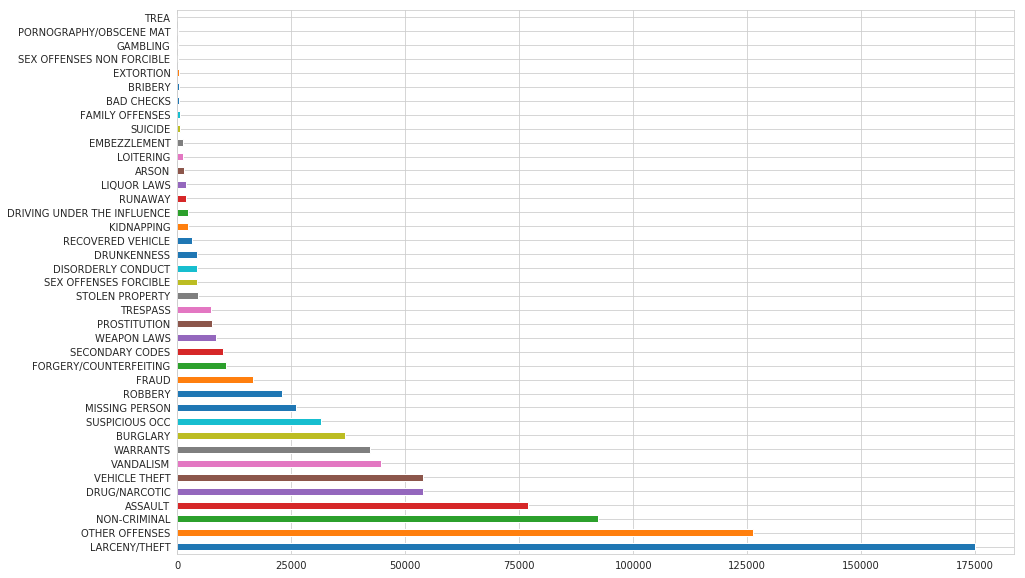

In [9]:
# Category

# Plot
crimes_df["Category"].value_counts().plot(kind='barh', figsize=(15,10))

In [10]:
# Dates

# Convert Date to Year, Month, and Week
crimes_df['Year']  = crimes_df['Dates'].apply(lambda x: int(str(x)[:4]))
crimes_df['Month'] = crimes_df['Dates'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Dates'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Dates'].apply(lambda x: int(str(x)[5:7]))

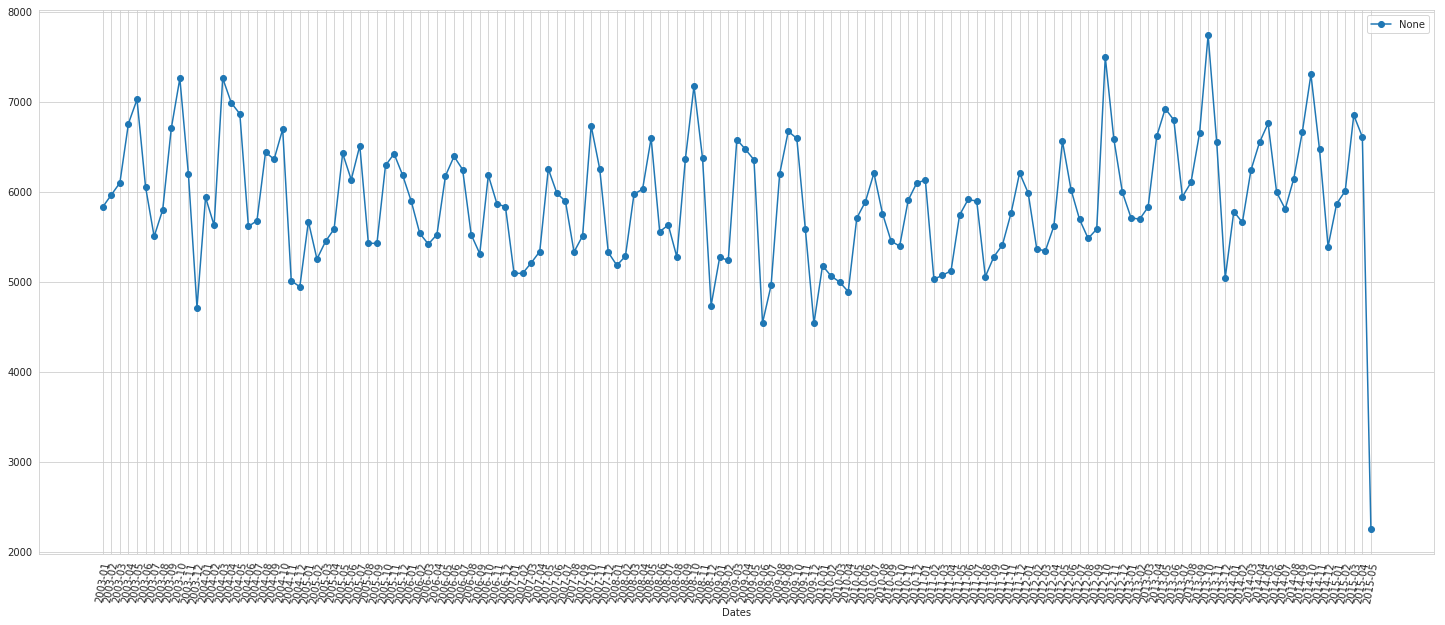

In [11]:
# .... continue with Dates

# Assign Dates column to Dates(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
crimes_df['Dates'] = crimes_df['Dates'].apply(lambda x: (str(x)[:7]))
test_df['Dates']   = test_df['Dates'].apply(lambda x: (str(x)[:7]))

# count number of crimes by Dates(Year-Month)
count_crimes  = crimes_df.groupby('Dates').size()
# crimes_pct_change  = crimes_df.groupby('Dates').size().pct_change()

fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(25,10))

# plot number of crimes over time(year-month)
ax1 = count_crimes.plot(legend=True,ax=axis1,marker='o')
ax1.set_xticks(range(len(count_crimes)))
xlabels = ax1.set_xticklabels(count_crimes.index.tolist(), rotation=80)

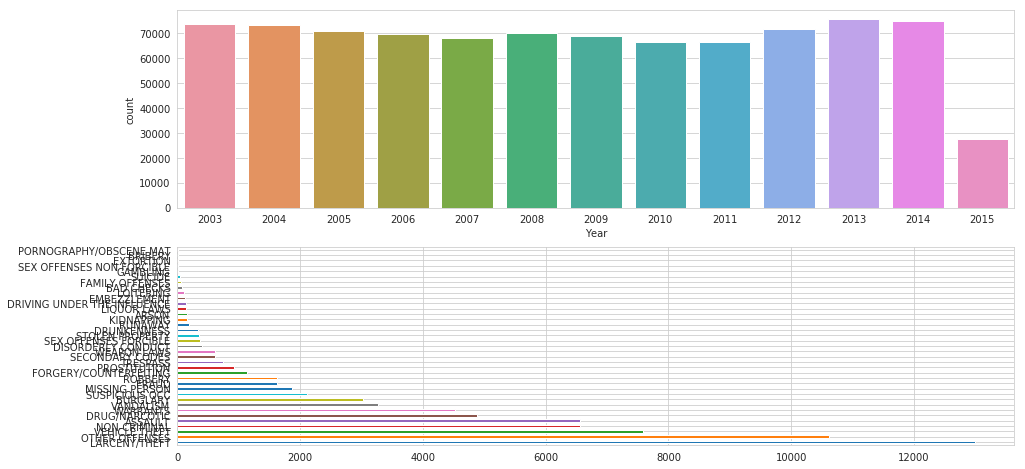

In [12]:
# year
# Which year has higher number of crimes

# Plot
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,8))

sns.countplot(x=crimes_df["Year"], ax=axis1)

# most frequent crimes in a year
crimes_df["Category"][crimes_df["Year"] == 2003].value_counts().plot(kind='barh', ax=axis2, ylim=(0,10))

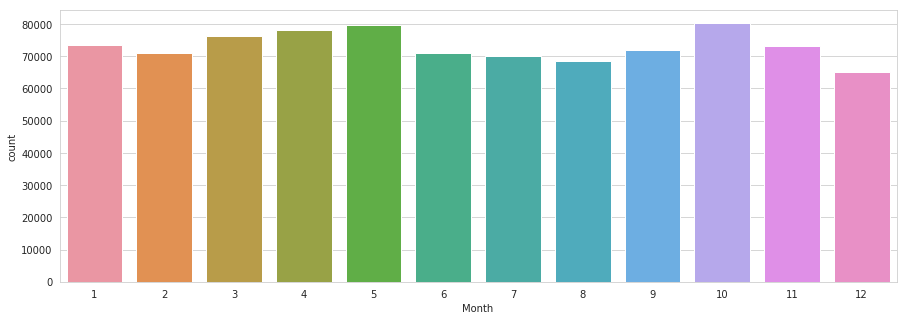

In [13]:
# month
# Which month has higher number of crimes

# Plot
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

sns.countplot(x=crimes_df["Month"], order=[1,2,3,4,5,6,7,8,9,10,11,12], ax=axis1)

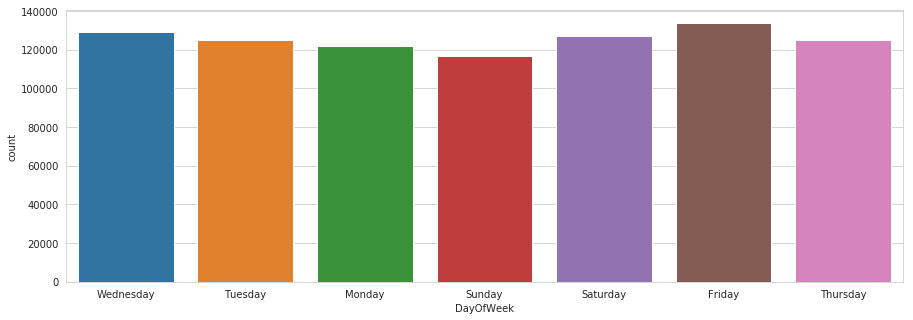

In [14]:
# Create dummy varibales for DayOfWeek
day_dummies_crimes  = pd.get_dummies(crimes_df['DayOfWeek'])
day_dummies_crimes.drop(['Sunday'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['DayOfWeek'])
day_dummies_test.drop(['Sunday'], axis=1, inplace=True)

crimes_df   = crimes_df.join(day_dummies_crimes)
test_df     = test_df.join(day_dummies_test)

# Plot
# Which DayOfWeek has higher number of crimes
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x=crimes_df["DayOfWeek"], ax=axis1)

crimes_df.drop(['DayOfWeek'], axis=1,inplace=True)
test_df.drop(['DayOfWeek'], axis=1,inplace=True)

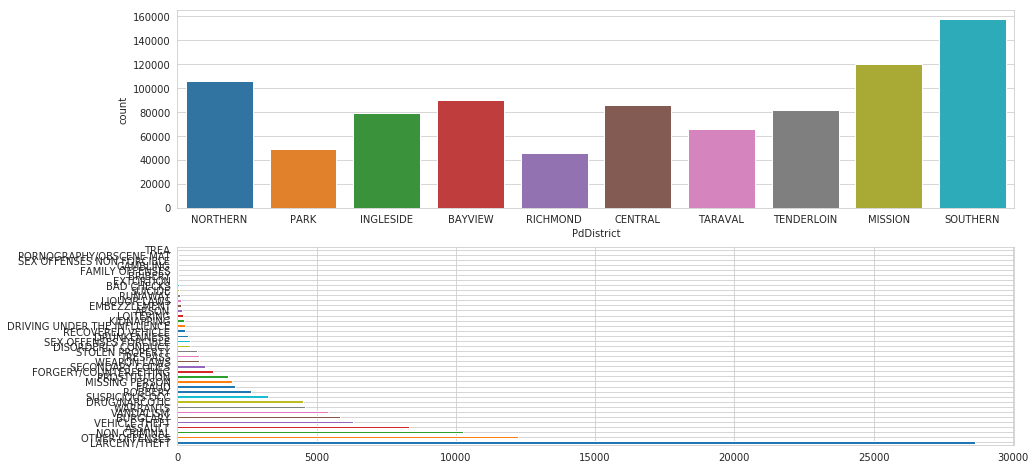

In [15]:
# Create dummy varibales for PdDistrict
day_dummies_crimes  = pd.get_dummies(crimes_df['PdDistrict'])
day_dummies_crimes.drop(['RICHMOND'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['PdDistrict'])
day_dummies_test.drop(['RICHMOND'], axis=1, inplace=True)

crimes_df   = crimes_df.join(day_dummies_crimes)
test_df     = test_df.join(day_dummies_test)

# Plot
# Which PdDistrict has higher number of crimes
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,8))
sns.countplot(x=crimes_df["PdDistrict"], ax=axis1)

# most frequent crimes in a PdDistrict
crimes_df["Category"][crimes_df["PdDistrict"] == 'NORTHERN'].value_counts().plot(kind='barh', ax=axis2, ylim=(0,10))

crimes_df.drop(['PdDistrict'], axis=1,inplace=True)
test_df.drop(['PdDistrict'], axis=1,inplace=True)

In [16]:
# drop Dates
crimes_df.drop(['Dates'], axis=1,inplace=True)
test_df.drop(['Dates'], axis=1,inplace=True)

# drop Year and Month
# crimes_df.drop(["Year", "Month"], axis=1, inplace=True)
# test_df.drop(["Year", "Month"], axis=1, inplace=True)

In [17]:
ordered_crimes   = crimes_df["Category"].value_counts().index.order()
map_values_dic   = Series(range(0,len(ordered_crimes)), index=ordered_crimes).to_dict()

crimes_df['Category'] = crimes_df['Category'].map(map_values_dic)

AttributeError: 'Index' object has no attribute 'order'

In [ ]:
# define training and testing sets

X_train = crimes_df.drop(["Category"],axis=1)
Y_train = crimes_df["Category"].copy()
X_test  = test_df.drop("Id",axis=1).copy()

In [ ]:
# Xgboost 

params = {"objective": "multi:softprob", "num_class": len(ordered_crimes)}

T_train_xgb = xgb.DMatrix(X_train, Y_train)
X_test_xgb  = xgb.DMatrix(X_test)

gbm = xgb.train(params, T_train_xgb, 20)
Y_pred = gbm.predict(X_test_xgb)

In [ ]:
# Create submission

i = 0

# Create column name based on ordered crime names(see sample_submission.csv)
with gzip.open('crimes.csv.gz', 'wt') as outf:
    fo = csv.writer(outf, lineterminator='\n')
    fo.writerow(['Id'] + list(ordered_crimes))
    
    for i, pred in enumerate(Y_pred):
        fo.writerow([i] + list(pred))